# Group 7 Python Script
    Yining Li (yl4038), Yuhe Yan (yy2892), Shujun Chen (sc4410)

## Data Preprocessing

### Data Description
#### Stock Infos: 
* Top 50 (based on market cap) Stocks from S&P 500

#### Index Infos: 
* Market Index: S&P 500
* Risk Free Rate: 1-Month Treasury Bill Rate (Symbol: 1MTB via Yahoo Finance)

#### Time Range: 
* 150 Weeks, From 05/20/2016 to 03/29/2019 

#### Data Frequency: 
* WEEKLY data for the last trading day of each week

In [55]:
#!pip install pandas-datareader
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')#  ggplot
# plt.style.use('seaborn')

import pandas_datareader.data as web
from pandas_datareader import data, wb
import pandas_datareader as pdr

import statsmodels.api as sm
import scipy.optimize as sco

import warnings
warnings.filterwarnings('ignore')

In [56]:
df_all = pd.read_excel('FINAL_DATASET.xlsx')
df_all.columns

Index(['MSFT', 'AAPL', 'AMZN', 'GOOGL', 'FB', 'JNJ', 'XOM', 'JPM', 'V', 'WMT',
       'BRK-B', 'BAC', 'PG', 'VZ', 'MA', 'INTC', 'CSCO', 'UNH', 'PFE', 'CVX',
       'T', 'WFC', 'BA', 'MRK', 'HD', 'KO', 'ORCL', 'CMCSA', 'PEP', 'DIS',
       'NFLX', 'C', 'MCD', 'ABT', 'PM', 'LLY', 'NKE', 'ADBE', 'IBM', 'MDT',
       'CRM', 'UNP', 'DWDP', 'MMM', 'AVGO', 'ABBV', 'AMGN', 'HON', 'ACN',
       'UTX', 'SP500', 'SP600_small', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA',
       'WBAA', 'WAAA', '1YTB', '^FVX', '^TNX', '1MTB'],
      dtype='object')

#### Symbols: 
From 'MSFT' to 'UTX': 
        
    S&P TOP 50 Close Prices, Not Adjusted

'SP500', 'SP600_small': 

    S&P 500, and 600-Small-Cap Index Value 

'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA': 

    FAMA-FRENCH 5 Factors.See Part II-APT (Weekly)

'WBAA', 'WAAA': 

    Moody's Baa and Aaa Corporate Bond Yield, Percent, Daily, Not Seasonally Adjusted (%, annual)
 
'1YTB', '^FVX', '^TNX','1MTB': 

    Treasury Yield of 1, 5, 10 Years and 1 month Treasury Bill Rate(%, annual) 
    * Use 1 month Treasury Bill Rate (1MTB) as the risk free rate

In [57]:
stock_df = df_all.iloc[:,:52].pct_change()[1:]  # Weekly return rate
stock_df.tail()

bond_df = df_all.iloc[:,-6:]/100/52   # Weekly real data(not percentage)
bond_df.tail()

,WBAA,WAAA,1YTB,^FVX,^TNX,1MTB
2019-03-01,0.000948,0.000738,0.000490,0.000492,0.000530,0.000469
2019-03-08,0.000946,0.000740,0.000487,0.000466,0.000505,0.000471
2019-03-15,0.000938,0.000735,0.000485,0.000462,0.000499,0.000473
2019-03-22,0.000929,0.000725,0.000471,0.000434,0.000472,0.000479
2019-03-29,0.000900,0.000698,0.000462,0.000431,0.000464,0.000467


# I. CAPM

### 1-1 Set Rm, Rf

In [58]:
rm = pd.DataFrame(stock_df['SP500'])
rf = pd.DataFrame(bond_df['1MTB'][1:])
rf.tail()

,1MTB
2019-03-01,0.000469
2019-03-08,0.000471
2019-03-15,0.000473
2019-03-22,0.000479
2019-03-29,0.000467


### 1-2 CAPM Model

In [59]:
# CAPM for Weekly Expect Return

def CAPM(ri,rm,rf,window=20):
    # Use historic rolling window to calculate the covariance & variance
    cov_im = pd.DataFrame(pd.concat([rm,ri],axis=1).rolling(window).cov().iloc[(window-1)*2::2,1])
    cov_im.index = date_index
    var_m = rm.rolling(window).var().iloc[window-1:].rename(columns={'SP500':ri.columns[0]})

    beta_i = cov_im/var_m
    beta = beta_i[:-1]
    beta.index=beta_i.index[1:]       
    
    exp_rm = rm[window:].rename(columns={'SP500':ri.columns[0]})
    exp_rf = rf[window:].rename(columns={'1MTB':ri.columns[0]})

    exp_return = exp_rf + beta*(exp_rm-exp_rf)       

    return exp_return

### 1-3 Get Expected Returns of Top 50 Stocks via CAPM

In [60]:
window_CAPM=16
date_index=rf.index[window_CAPM-1:]
expect_return_CAPM = rm[window_CAPM:]

for stock in stock_df.columns[:50]:
    ri = pd.DataFrame(stock_df[stock])
    exp_returni = CAPM(ri,rm,rf,window_CAPM)
    expect_return_CAPM = pd.concat([expect_return_CAPM,exp_returni],axis=1)
    
expect_return_CAPM = expect_return_CAPM.iloc[-1:,1:]
expect_return_CAPM # S&P 500 represent the real values

,MSFT,AAPL,AMZN,GOOGL,FB,JNJ,XOM,JPM,V,WMT,...,CRM,UNP,DWDP,MMM,AVGO,ABBV,AMGN,HON,ACN,UTX
2019-03-29,0.011797,0.013709,0.01842,0.011021,0.013747,0.006439,0.012724,0.013419,0.013031,0.009959,...,0.018342,0.013679,0.010123,0.011587,0.009229,0.009154,0.013718,0.010957,0.014871,0.01229


In [61]:
# expect_return_CAPM.to_excel('CAPM_expect_return.xlsx')

In [62]:
# real = pd.DataFrame(stock_df.iloc[-1,:50]).T
# plt.scatter(expect_return_CAPM*52,real*52)

# II. APT

### Candidate Factors:

### a. F-F 3 Factors: Ri - Rf = β3 * ( Rm - Rf ) + bs * SMB + bv * HML + α
    r = portfolio's return rate
    Rf = risk-free return rate
    Rm = whole stock market return rate

* SMB: small cap minus big
* HML: high book/price minus low
    measure the historic excess returns of small caps and "value" stocks over the market as a whole

        corresponding coefficients bs and bv: take values on a scale of roughly 0 to 1:   
        bs = 1 would be a small cap portfolio, bs = 0 would be large cap     
        bv = 1 would be a portfolio with a high book/price ratio


### b. F-F 5 Factors： Ri - Rf = β5 * ( Rm - Rf ) + bs * SMB + bv * HML + br * RMW + bc * CMA + α
* RMW: robust stk portfolios return -  weak stk portfolios return (diversified)
* CMA:  low investment firms stk portfolios returns - high investment firms stk portfolios returns (diversified)


    Ideally, if the exposures to the five factors, β5, bs, bv, br, and bc, capture all variation in expected returns, the intercept α is zero for all securities and portfolios

### c. Other Factors

* Credit risk: Baa corporate bond yield - Treasult Yield bond
        
* Term structure factor: 10yr Treasury Yield - 1yr Treasury Yield


#### We applied OLS to determine which factors would be used in APT model, and the p-values of Credit risk & Term Structure didn't show significant influences compared with Fama-French 5 factors. Hence we chose F-F 5 factors as our APT Factors.

### 2-1 Factor Selection

In [63]:
factor_df = df_all[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]/100  # del percentage
factor_df['Credit'] = (bond_df['WBAA']-bond_df['^TNX'])
factor_df['Term'] = (bond_df['^TNX'] - bond_df['1YTB'])
factor_df.tail(5)

,Mkt-RF,SMB,HML,RMW,CMA,Credit,Term
2019-03-01,0.0049,-0.0052,-0.0143,-0.0131,-0.0086,0.000418,3.942310e-05
2019-03-08,-0.0257,-0.0194,-0.0023,0.0047,-0.0011,0.000441,1.826923e-05
2019-03-15,0.0280,-0.0101,-0.0054,-0.0110,-0.0060,0.000440,1.403845e-05
2019-03-22,-0.0108,-0.0190,-0.0260,0.0073,-0.0020,0.000457,9.615238e-07
2019-03-29,0.0127,0.0108,-0.0031,0.0108,0.0009,0.000436,2.692314e-06


#### Visualization the Correlation

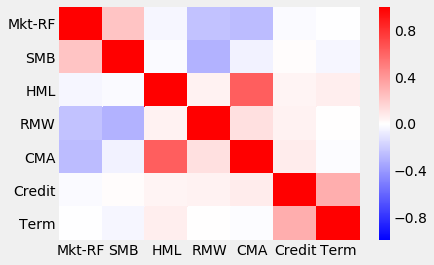

In [64]:
# plt.figure(figsize=(6,4))
sns.heatmap(factor_df.corr(), vmax=1,vmin = -1, xticklabels= True, yticklabels= True,cmap="bwr")  

### 2-2 APT Model

In [65]:
def APT(ri, rf, factor_df, window=150):
    import statsmodels.api as sm
    y = np.array(ri[-window:])-np.array(rf[-window:] )  # Y = Ri-Rf
    X = sm.add_constant(factor_df.iloc[-window:])    # APT factors
    model = sm.OLS(y, X).fit()
    # model.summary()
    expect = model.predict()[-1] + rf.iloc[-1,0]
    intercept = model.params[0]
    pvalues = model.pvalues
    tvalues = model.tvalues
    rsquare = model.rsquared
    
    return expect, intercept, pvalues, rsquare

### 2-3 Get Expected Returns of top 50 via APT

In [66]:
window_APT = 150 # weeks

expect_list = []; alpha_list = []; p_list = []; r2_list = []

for stock in stock_df.columns[:50]:
    ri = pd.DataFrame(stock_df[stock])
    expect, alpha ,p,r2 = APT(ri, rf, factor_df.iloc[:,:5], window_APT)
    expect_list.append(expect) 
    alpha_list.append(alpha)
    p_list.append(p)
    r2_list.append(r2)
    
    
expect_return_APT = pd.DataFrame(expect_list,index = stock_df.columns[:50],columns=['expect_return'])
alpha_df = pd.DataFrame(alpha_list,index = stock_df.columns[:50],columns=['alpha_value'])
r2_df = pd.DataFrame(r2_list,index = stock_df.columns[:50],columns=['R_square'])
p_df = pd.DataFrame(p_list,index = stock_df.columns[:50])
ols_df = pd.concat([expect_return_APT, alpha_df, r2_df, p_df],axis=1)
ols_df.head(10)

,expect_return,alpha_value,R_square,const,Mkt-RF,SMB,HML,RMW,CMA
MSFT,0.012621,0.002351,0.678222,0.044734,3.695909e-29,0.000103,6.735840e-01,0.190921,0.000084
AAPL,0.007103,0.001706,0.407689,0.445872,1.864504e-09,0.059315,7.010525e-02,0.549423,0.002052
AMZN,0.010592,0.002142,0.610384,0.246532,4.841167e-20,0.093364,6.800438e-04,0.067484,0.005199
GOOGL,0.002279,-0.000185,0.643056,0.899419,3.625292e-23,0.000629,7.510430e-02,0.005615,0.000369
FB,0.002253,-0.001166,0.478574,0.601253,6.053901e-11,0.475257,1.102160e-03,0.009256,0.019747
JNJ,0.008842,-0.000428,0.381268,0.767599,3.537385e-16,0.001400,7.216225e-01,0.225194,0.139623
XOM,-0.000438,-0.002139,0.545081,0.129891,3.292927e-21,0.020068,9.970946e-01,0.000178,0.000833
JPM,0.007591,0.001499,0.810628,0.164735,3.872692e-36,0.734407,1.873237e-29,0.091083,0.000001
V,0.008918,0.001689,0.727719,0.090491,6.014523e-33,0.004564,2.380306e-02,0.102867,0.001160
WMT,0.018553,0.001045,0.225322,0.612939,8.973408e-09,0.119162,7.178201e-01,0.001940,0.244708


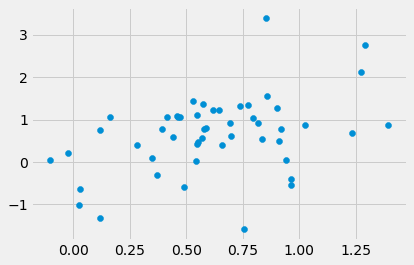

In [67]:
expect_return_APT = pd.DataFrame(ols_df['expect_return']).T
expect_return_APT.index = [stock_df.index[-1]]

real = pd.DataFrame(stock_df.iloc[-1,:50]).T

# plt.figure(figsize=(6, 4))
# plt.xlim(-0.01,0.03)
plt.scatter(expect_return_APT*52, real*52)

# expect_return_APT.to_excel('APT_expect_return.xlsx')

# III. Markowitz

## 3-1 Short Allowed, No Cash

#### Get Annualized Data First

In [68]:
# Latest Version——Annualized
window=150
Rf=rf.iloc[-1,0] * 52  # annualized

cov_matrix = stock_df.iloc[-window-1:-1,:50].cov()*52   # Annualized cov via historic data
cov_V = np.matrix(cov_matrix.as_matrix())


def get_return_sigma(expect_annual_return, cov_V, weight):
    weight = np.matrix(weight).T
    fund_return = np.dot(weight.T,expect_annual_return)[0,0]
    fund_sigma = np.sqrt(np.dot(weight.T,np.dot(cov_V,weight)))[0,0]    
    fund_sharpe = (fund_return-Rf)/fund_sigma
    return [fund_return,fund_sigma,fund_sharpe]

def short_allow_no_cash(expect_annual_return, cov_V, Rf):
    two_portf = np.zeros((3,2))
    two_weights = np.zeros((50,2))

    e=np.ones(50)
    V_I = cov_V.I
    q = np.array(expect_annual_return - Rf)

    Cee=np.dot(np.dot(e.T,V_I),e)
    Ceq=np.dot(np.dot(e.T,V_I),q)

    max_sharpe_w = np.array(np.dot(V_I,q)/Ceq)[0]
    min_var_w = np.array(np.dot(V_I,e)/Cee)[0]

    max_sharpe_portf=get_return_sigma(expect_annual_return, cov_V, max_sharpe_w)
    min_var_portf   =get_return_sigma(expect_annual_return, cov_V, min_var_w)

    two_portf[:,0] = max_sharpe_portf
    two_portf[:,1] = min_var_portf

    two_weights[:,0] = max_sharpe_w
    two_weights[:,1] = min_var_w

    portf = pd.DataFrame(two_portf,index =['Return','Sigma','Sharpe'], columns=['Max_Sharpe','Min_Var'])
    weights = pd.DataFrame(two_weights,index =stock_df.columns[:50], columns=['Max_Sharpe','Min_Var'])

    return portf, weights

### Plot the Efficient Frontiers based on the expected returns calculated by CAPM & APT separately

When expected returns calculated via CAPM:
Max Sharpe Allocation:
Annual Return:     2.042307
Annual Volatility: 0.281886

Min Volatility Allocation
Annual Return:     0.221765
Annual Volatility: 0.088177


When expected returns calculated via APT:
Max Sharpe Allocation:
Annual Return:     3.104572
Annual Volatility: 0.209640

Min Volatility Allocation
Annual Return:     0.569244
Annual Volatility: 0.088177



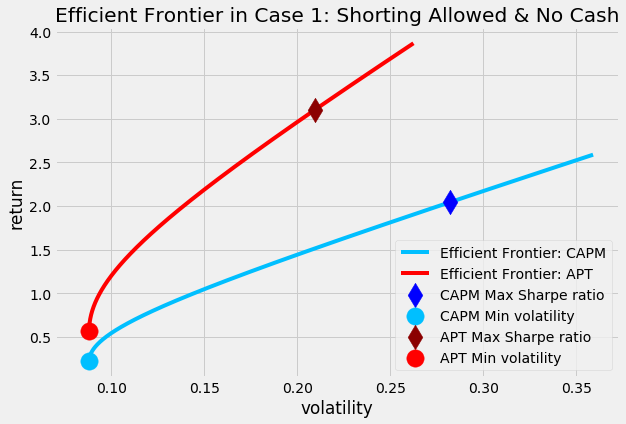

In [69]:
def plot_EF_1(portf, weights):

    r_Max_Sharpe = portf['Max_Sharpe']['Return']
    v_Max_Sharpe = portf['Max_Sharpe']['Sigma']
    s_Max_Sharpe = portf['Max_Sharpe']['Sharpe']

    r_Min_Var = portf['Min_Var']['Return']
    v_Min_Var = portf['Min_Var']['Sigma']
    s_Min_Var = portf['Min_Var']['Sharpe']

    ratio = np.linspace(0,1.3,500)

    R_array = ratio*r_Max_Sharpe+(1-ratio)*r_Min_Var
    cov_two_portf =np.dot(np.dot(np.matrix(weights['Max_Sharpe']),cov_V),np.matrix(weights['Min_Var']).T)[0,0]
    var_array = np.power(ratio,2)*v_Max_Sharpe**2+np.power(1-ratio,2)*v_Min_Var**2+2*ratio*(1-ratio)*cov_two_portf
    S_array = np.power(var_array,0.5)    

    print ("Max Sharpe Allocation:\nAnnual Return:     %.6f\nAnnual Volatility: %.6f\n"%(r_Max_Sharpe,v_Max_Sharpe))
    print ("Min Volatility Allocation\nAnnual Return:     %.6f\nAnnual Volatility: %.6f\n"%(r_Min_Var,v_Min_Var))
    
    return S_array,R_array, v_Max_Sharpe,r_Max_Sharpe, v_Min_Var, r_Min_Var

portf_short_allow_no_cash_CAPM, weights_short_allow_no_cash_CAPM = short_allow_no_cash(expect_return_CAPM.iloc[-1] * 52, cov_V, Rf)

print('When expected returns calculated via CAPM:')
vol_CAPM_1, return_CAPM_1, v_Max_Sharpe_CAPM_1, r_Max_Sharpe_CAPM_1, v_Min_Var_CAPM_1, r_Min_Var_CAPM_1 = \
        plot_EF_1(portf_short_allow_no_cash_CAPM, weights_short_allow_no_cash_CAPM)

portf_short_allow_no_cash_APT, weights_short_allow_no_cash_APT = short_allow_no_cash(expect_return_APT.iloc[-1]*52, cov_V, Rf)
print('\nWhen expected returns calculated via APT:')
vol_APT_1, return_APT_1, v_Max_Sharpe_APT_1, r_Max_Sharpe_APT_1, v_Min_Var_APT_1, r_Min_Var_APT_1 = \
        plot_EF_1(portf_short_allow_no_cash_APT, weights_short_allow_no_cash_APT)


plt.figure(figsize=(9, 6))
# plt.xlim(0.075,0.25)
# plt.ylim(-0.5,3.5)

plt.scatter(v_Max_Sharpe_CAPM_1,r_Max_Sharpe_CAPM_1, zorder=5,color='b',          marker='d',s=300, label='CAPM Max Sharpe ratio')
plt.scatter(v_Min_Var_CAPM_1,   r_Min_Var_CAPM_1,    zorder=5,color='deepskyblue',marker='o',s=300, label='CAPM Min volatility')
plt.plot(vol_CAPM_1,return_CAPM_1,zorder=1,color='deepskyblue', label='Efficient Frontier: CAPM')

plt.scatter(v_Max_Sharpe_APT_1, r_Max_Sharpe_APT_1, zorder=5, color='darkred',s=300, marker='d',label='APT Max Sharpe ratio')
plt.scatter(v_Min_Var_APT_1,    r_Min_Var_APT_1,    zorder=5, color='r',    s=300, marker='o',label='APT Min volatility')
plt.plot(vol_APT_1,return_APT_1, zorder=1,color='r', label='Efficient Frontier: APT')

plt.title('Efficient Frontier in Case 1: Shorting Allowed & No Cash')
plt.xlabel('volatility')
plt.ylabel('return')
plt.legend(labelspacing=0.5)

plt.show()

In [70]:
weights_short_allow_no_cash_APT

,Max_Sharpe,Min_Var
MSFT,0.277404,0.071965
AAPL,0.124571,0.075693
AMZN,0.011698,-0.017513
GOOGL,-0.422769,-0.095518
FB,-0.166608,0.022223
JNJ,-0.004972,0.091906
XOM,-0.295335,0.054974
JPM,-0.199159,0.305118
V,-0.174214,-0.051180
WMT,-0.081320,0.092382


## 3-2 Short Allowed, With Cash

In [71]:
def get_twoportf_cov(weight1, cov_V, weight2):
    cov_mat = pd.DataFrame(np.zeros((2,2)))
    fund_var1 = np.dot(np.dot(weight1,cov_V),weight1)[0,0]    
    fund_var2 = np.dot(np.dot(weight2,cov_V),weight2)[0,0]        
    fund_cov = np.dot(np.dot(weight1,cov_V),weight2)[0,0]
    cov_list = np.array([[fund_var1,fund_cov],[fund_cov,fund_var2]])
    cov_portf = pd.DataFrame(cov_list,columns=['Max_Sharpe','Min_Var'],index = ['Max_Sharpe','Min_Var'])
    return cov_portf

def short_allow_with_cash(expect_annual_return, cov_V, Rf):
    
    e=np.ones(2)
    V_I = cov_V.I
    sigma =np.array([np.sqrt(cov_V)[0,0],np.sqrt(cov_V)[1,1]])
    q = np.array(expect_annual_return - Rf)
    
    v1 = np.dot(V_I,e)
    v2 = np.dot(V_I,q)
    
    weights = ((v2-Rf*v1)/np.sum(v2-Rf*v1)).tolist()[0]
    
    portf_return = sum(weights * expect_annual_return)    
    portf_sigma = sum(weights * sigma)
    
    return portf_return, portf_sigma, weights


Rf=rf.iloc[-1,0] * 52  # annualized
cov_matrix = stock_df.iloc[-window-1:-1,:50].cov()*52
cov_V = np.matrix(cov_matrix.as_matrix())

### Plot the new EF (solid line)  in Case2, and compare with the former EFs (dotted line) in Case 1
#### When cash is allowed, the EF bacomes a straight line

7.355915592998894
14.85585682248534


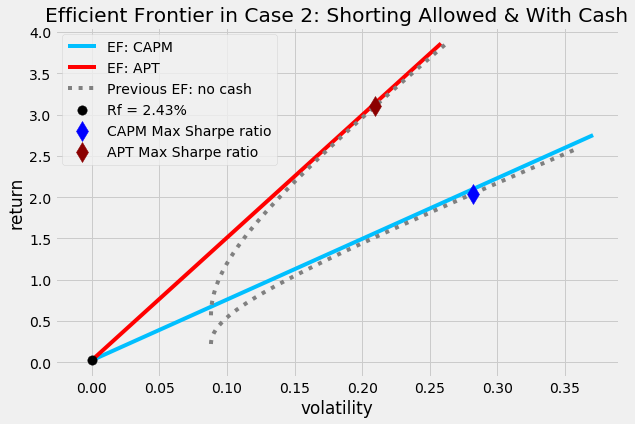

In [72]:
def plot_EF_2(portf_return, portf_sigma, Rf):
    
    S_array = np.linspace(0,portf_sigma*1.2,500)
    R_array = (portf_return-Rf)/portf_sigma * S_array + Rf
#     print((portf_return-Rf)/portf_sigma)
    return S_array,R_array


portf_short_allow_no_cash_CAPM, weights_short_allow_no_cash_CAPM = short_allow_no_cash(expect_return_CAPM.iloc[-1] * 52, cov_V, Rf)
weight1 = weights_short_allow_no_cash_CAPM['Max_Sharpe']
weight2 = weights_short_allow_no_cash_CAPM['Min_Var']
cov_portf_CAPM = get_twoportf_cov(weight1, cov_V, weight2)
cov_portf_CAPM = np.matrix(cov_portf_CAPM.as_matrix())

internal_return_CAPM, internal_sigma_CAPM, internal_weight_CAPM = \
        short_allow_with_cash(portf_short_allow_no_cash_CAPM.loc['Return'], cov_portf_CAPM, Rf)

vol_CAPM_2,return_CAPM_2 = plot_EF_2(internal_return_CAPM, internal_sigma_CAPM, Rf)


portf_short_allow_no_cash_APT, weights_short_allow_no_cash_APT = short_allow_no_cash(expect_return_APT.iloc[-1]*52, cov_V, Rf)
weight1 = weights_short_allow_no_cash_APT['Max_Sharpe']
weight2 = weights_short_allow_no_cash_APT['Min_Var']
cov_portf_APT = get_twoportf_cov(weight1, cov_V, weight2)
cov_portf_APT = np.matrix(cov_portf_APT.as_matrix())

internal_return_APT, internal_sigma_APT, internal_weight_APT = \
        short_allow_with_cash(portf_short_allow_no_cash_APT.loc['Return'], cov_portf_APT, Rf)

vol_APT_2,return_APT_2 = plot_EF_2(internal_return_APT, internal_sigma_APT, Rf)


plt.figure(figsize=(9, 6))
# plt.ylim(-0.5,3.5)
# plt.xlim(-0.001,0.05)

plt.scatter(0, Rf, marker='.',color='black',s=350, label='Rf = %.2f%%'%(Rf*100),zorder=5)

plt.plot(vol_CAPM_2,return_CAPM_2,zorder=1,color='deepskyblue',label = 'EF: CAPM')
plt.plot(vol_APT_2,return_APT_2, zorder=1,color='r',label='EF: APT')


plt.scatter(v_Max_Sharpe_CAPM_1,r_Max_Sharpe_CAPM_1, marker='d',color='b',s=200, zorder=5, label='CAPM Max Sharpe ratio')
# plt.scatter(v_Min_Var_CAPM_1, r_Min_Var_CAPM_1,marker='o',color='deepskyblue',s=200, zorder=5, label='CAPM Min volatility')
plt.plot(vol_CAPM_1,return_CAPM_1,zorder=1,linestyle=':', color='grey',label='Previous EF: no cash')

plt.scatter(v_Max_Sharpe_APT_1, r_Max_Sharpe_APT_1, marker='d',color='darkred',s=200, zorder=5, label='APT Max Sharpe ratio')
# plt.scatter(v_Min_Var_APT_1, r_Min_Var_APT_1, marker='o',color='red',s=200, zorder=5, label='APT Min volatility')
plt.plot(vol_APT_1,return_APT_1, zorder=1,linestyle=':', color='grey')

plt.title('Efficient Frontier in Case 2: Shorting Allowed & With Cash')
plt.xlabel('volatility')
plt.ylabel('return')
plt.legend(labelspacing=0.5)

plt.show()

In [73]:
portf_short_allow_no_cash_CAPM

,Max_Sharpe,Min_Var
Return,2.042307,0.221765
Sigma,0.281886,0.088177
Sharpe,7.158957,2.239407


### Plot in Two subplots

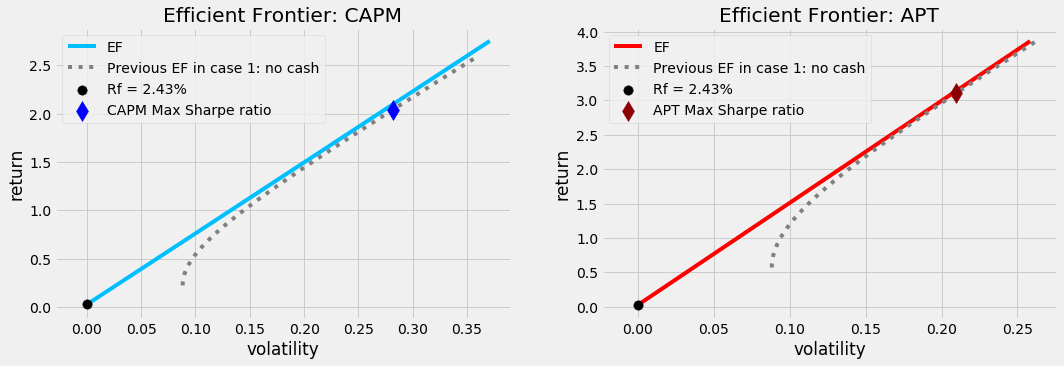

In [74]:
# PLOT in Two Figures
fig, axes = plt.subplots(1, 2, figsize=(16,5))

ax0 = axes[0]
ax0.scatter(0, Rf, marker='.',color='black',s=350, label='Rf = %.2f%%'%(Rf*100),zorder=5)
ax0.plot(vol_CAPM_2,return_CAPM_2,zorder=1,color='deepskyblue',label='EF')
ax0.scatter(v_Max_Sharpe_CAPM_1,r_Max_Sharpe_CAPM_1, marker='d',color='b',s=200, zorder=5, label='CAPM Max Sharpe ratio')
# ax0.scatter(v_Min_Var_CAPM_1, r_Min_Var_CAPM_1,marker='o',color='deepskyblue',s=200, zorder=5, label='CAPM Min volatility')

ax0.plot(vol_CAPM_1,return_CAPM_1,zorder=1,color='grey',linestyle=':',label='Previous EF in case 1: no cash')
ax0.set_title('Efficient Frontier: CAPM')
ax0.set_xlabel('volatility')
ax0.set_ylabel('return')
ax0.legend(labelspacing=0.5)

ax1 = axes[1]
ax1.scatter(0, Rf, marker='.',color='black',s=350, label='Rf = %.2f%%'%(Rf*100),zorder=5)
ax1.plot(vol_APT_2,return_APT_2, zorder=1,color='r',label='EF')
ax1.scatter(v_Max_Sharpe_APT_1, r_Max_Sharpe_APT_1, marker='d',color='darkred',s=200, zorder=5, label='APT Max Sharpe ratio')
# ax1.scatter(v_Min_Var_APT_1, r_Min_Var_APT_1, marker='o',color='red',s=200, zorder=5, label='APT Min volatility')

ax1.plot(vol_APT_1,return_APT_1, zorder=1,color='grey',linestyle=':',label='Previous EF in case 1: no cash')
ax1.set_title('Efficient Frontier: APT')
ax1.set_xlabel('volatility')
ax1.set_ylabel('return')
ax1.legend(labelspacing=0.5)

# plt.tight_layout() 
plt.show()

## 3-3 No Short, No Cash
Import scipy.optimize to solve this quadratic programming problem

In [75]:
def no_short_no_cash(expect_annual_return, cov_V, Rf):
    
    ### GET Max Sharpe Portfolio
    def neg_sharpe_ratio(weights, expect_annual_return, cov_matrix, Rf):
        p_ret,p_std,p_sp = get_return_sigma(expect_annual_return, cov_matrix,weights)
        return -(p_ret - Rf) / p_std

    def max_sharpe_ratio(expect_annual_return, cov_matrix, Rf):
        stock_num = len(expect_annual_return)
        args = (expect_annual_return, cov_matrix, Rf)

        # Constraints: ∑x == 1, where 0<=x<=1
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0.0,1.0) for stock in range(stock_num))
        result = sco.minimize(neg_sharpe_ratio, stock_num*[1./stock_num,], args=args,
                              method='SLSQP', bounds=bounds, constraints=constraints)
        return result['x'] #,result['fun']

    ### GET Min Var Portfolio
    def portfolio_volatility(weights, expect_annual_return, cov_matrix):
        return  get_return_sigma(expect_annual_return, cov_matrix, weights)[1]

    def min_variance(expect_annual_return, cov_matrix):
        stock_num = len(expect_annual_return)
        args = (expect_annual_return, cov_matrix)

        # Constraints: ∑x == 1, where 0<=x<=1
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0.0,1.0) for stock in range(stock_num))    
        result = sco.minimize(portfolio_volatility, stock_num*[1./stock_num,], args=args,
                              method='SLSQP', bounds=bounds, constraints=constraints)
        
        return result['x'] #,result['fun']
    
    max_sharpe_w = max_sharpe_ratio(expect_annual_return, cov_matrix, Rf)
    min_var_w = min_variance(expect_annual_return, cov_matrix)
    
    max_sharpe_portf = get_return_sigma(expect_annual_return, cov_matrix,max_sharpe_w.T)
    min_var_portf = get_return_sigma(expect_annual_return, cov_matrix, min_var_w.T)

    
    two_portf = np.zeros((3,2))
    two_weights = np.zeros((50,2))

    two_portf[:,0] = max_sharpe_portf
    two_portf[:,1] = min_var_portf

    two_weights[:,0] = max_sharpe_w
    two_weights[:,1] = min_var_w

    portf = pd.DataFrame(two_portf,index =['Return','Sigma','Sharpe'], columns=['Max_Sharpe','Min_Var'])
    weights = pd.DataFrame(two_weights,index =stock_df.columns[:50], columns=['Max_Sharpe','Min_Var'])

    return portf, weights

In [76]:
def plot_EF_3(portf, weights, expect_annual_return):
    r_Max_Sharpe = portf['Max_Sharpe']['Return']
    v_Max_Sharpe = portf['Max_Sharpe']['Sigma']
    
    r_Min_Var = portf['Min_Var']['Return']
    v_Min_Var = portf['Min_Var']['Sigma']

    
    def portfolio_return(weights):
        return  get_return_sigma(expect_annual_return, cov_matrix, weights)[0]
    def portfolio_volatility(weights, expect_annual_return, cov_matrix):
        return  get_return_sigma(expect_annual_return, cov_matrix, weights)[1]
    
    stock_num = len(expect_annual_return)
    S_array = []
    args = (expect_annual_return, cov_matrix)
    
    R_array = np.linspace(r_Min_Var,r_Max_Sharpe*1.15,20)

    for ret in R_array:
        constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - ret},
                       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0,1) for stock in range(stock_num))
        result = sco.minimize(portfolio_volatility, stock_num*[1./stock_num,], args=args, 
                              method='SLSQP', bounds=bounds, constraints=constraints)
        S_array.append(result['fun'])

    print ("Max Sharpe Allocation:\nAnnual Return:     %.6f\nAnnual Volatility: %.6f\n"%(r_Max_Sharpe,v_Max_Sharpe))
    print ("Min Volatility Allocation\nAnnual Return:     %.6f\nAnnual Volatility: %.6f\n"%(r_Min_Var,v_Min_Var))
    
    return S_array,R_array, v_Max_Sharpe,r_Max_Sharpe, v_Min_Var, r_Min_Var


When expected returns calculated via CAPM:
Max Sharpe Allocation:
Annual Return:     0.913877
Annual Volatility: 0.151344

Min Volatility Allocation
Annual Return:     0.392161
Annual Volatility: 0.103685


When expected returns calculated via APT:
Max Sharpe Allocation:
Annual Return:     1.107004
Annual Volatility: 0.119475

Min Volatility Allocation
Annual Return:     0.644401
Annual Volatility: 0.103685



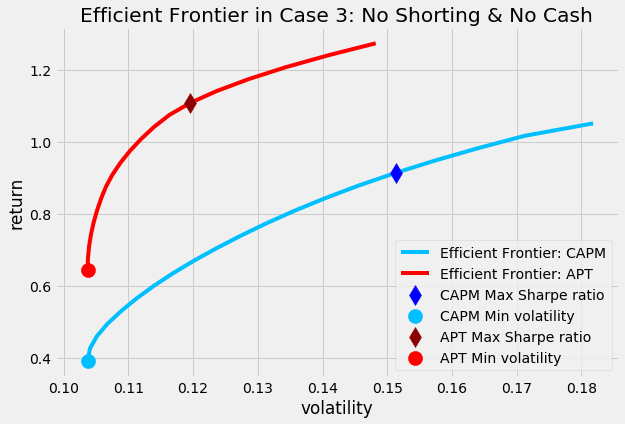

In [77]:
import scipy.optimize as sco

Rf=rf.iloc[-1,0] * 52  # annualized
cov_matrix = stock_df.iloc[-window-1:-1,:50].cov()*52
cov_V = np.matrix(cov_matrix.as_matrix())

###### CAPM
portf_no_short_no_cash_CAPM, weights_no_short_no_cash_CAPM = no_short_no_cash(expect_return_CAPM.iloc[-1] * 52, cov_V, Rf)
print('\nWhen expected returns calculated via CAPM:')
vol_CAPM_3, return_CAPM_3, v_Max_Sharpe_CAPM_3, r_Max_Sharpe_CAPM_3, v_Min_Var_CAPM_3, r_Min_Var_CAPM_3 = \
        plot_EF_3(portf_no_short_no_cash_CAPM, weights_no_short_no_cash_CAPM, expect_return_CAPM.iloc[-1] * 52)


###### APT
portf_no_short_no_cash_APT, weights_no_short_no_cash_APT = no_short_no_cash(expect_return_APT.iloc[-1] * 52, cov_V, Rf)
print('\nWhen expected returns calculated via APT:')
vol_APT_3, return_APT_3, v_Max_Sharpe_APT_3, r_Max_Sharpe_APT_3, v_Min_Var_APT_3, r_Min_Var_APT_3 = \
        plot_EF_3(portf_no_short_no_cash_APT, weights_no_short_no_cash_APT, expect_return_APT.iloc[-1] * 52)



plt.figure(figsize=(9, 6))
# plt.xlim(0,0.18)
# plt.ylim(0.2,1.4)

# CAPM
plt.scatter(v_Max_Sharpe_CAPM_3,r_Max_Sharpe_CAPM_3, marker='d',color='b',s=200, zorder=5, label='CAPM Max Sharpe ratio')
plt.scatter(v_Min_Var_CAPM_3, r_Min_Var_CAPM_3, marker='o',color='deepskyblue',s=200, zorder=5, label='CAPM Min volatility')
plt.plot(vol_CAPM_3, return_CAPM_3, color='deepskyblue', label='Efficient Frontier: CAPM')
# APT
plt.scatter(v_Max_Sharpe_APT_3,r_Max_Sharpe_APT_3, marker='d',color='darkred',s=200, zorder=5, label='APT Max Sharpe ratio')
plt.scatter(v_Min_Var_APT_3, r_Min_Var_APT_3, marker='o',color='r',s=200, zorder=5, label='APT Min volatility')
plt.plot(vol_APT_3, return_APT_3, color='r', label='Efficient Frontier: APT')

#######
#######Comparition
'''
# CAPM
plt.scatter(v_Max_Sharpe_CAPM_1,r_Max_Sharpe_CAPM_1, marker='*',color='b',s=200, zorder=5)
plt.scatter(v_Min_Var_CAPM_1, r_Min_Var_CAPM_1,marker='*',color='deepskyblue',s=200, zorder=5)
plt.plot(vol_CAPM_1,return_CAPM_1,zorder=1,linestyle='-.', color='deepskyblue',label='EF w.shorting: CAPM')
# APT
plt.scatter(v_Max_Sharpe_APT_1,r_Max_Sharpe_APT_1, marker='*',color='darkred',s=200, zorder=5)
plt.scatter(v_Min_Var_APT_1, r_Min_Var_APT_1,marker='*',color='r',s=200, zorder=5)
plt.plot(vol_APT_1,return_APT_1,zorder=1,linestyle=':', color='r',label='EF w.shorting: APT')
# '''

plt.title('Efficient Frontier in Case 3: No Shorting & No Cash')
plt.xlabel('volatility')
plt.ylabel('return')
plt.legend(labelspacing=0.5)
plt.show()

### PLOT in Two Figures
### Compare with EFs in case 1, the new EFs (solid line) become narrow when shorting is not allowed 

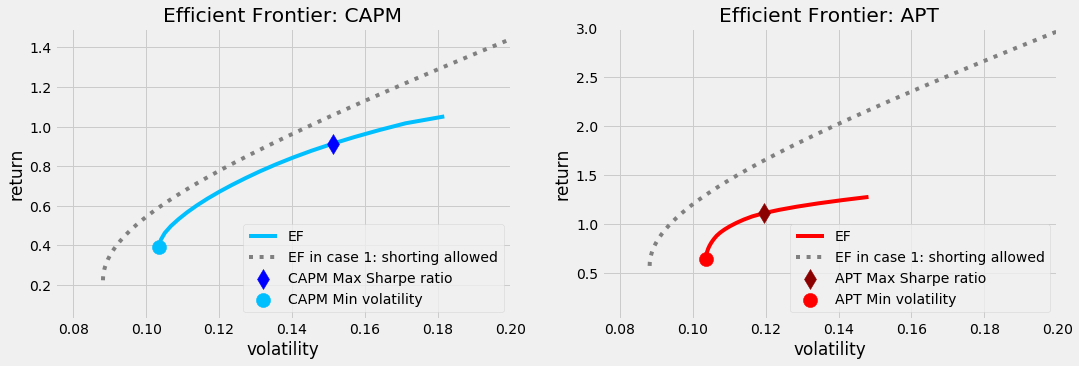

In [78]:
# PLOT in Two Figures
fig, axes = plt.subplots(1, 2, figsize=(16,5))

ax0 = axes[0]
ax0.plot(vol_CAPM_3,return_CAPM_3,zorder=1,color='deepskyblue',label='EF')
ax0.scatter(v_Max_Sharpe_CAPM_3,r_Max_Sharpe_CAPM_3, marker='d',color='b',s=200, zorder=5, label='CAPM Max Sharpe ratio')
ax0.scatter(v_Min_Var_CAPM_3, r_Min_Var_CAPM_3,marker='o',color='deepskyblue',s=200, zorder=5, label='CAPM Min volatility')

ax0.plot(vol_CAPM_1,return_CAPM_1,zorder=1,color='grey',linestyle=':',label='EF in case 1: shorting allowed')
ax0.set_title('Efficient Frontier: CAPM')
ax0.set_xlabel('volatility')
ax0.set_ylabel('return')
ax0.legend(labelspacing=0.5)
ax0.set_xlim(0.075,0.2)
ax0.set_ylim(Rf,1.5)

ax1 = axes[1]
ax1.plot(vol_APT_3,return_APT_3, zorder=1,color='r',label='EF')
ax1.scatter(v_Max_Sharpe_APT_3, r_Max_Sharpe_APT_3, marker='d',color='darkred',s=200, zorder=5, label='APT Max Sharpe ratio')
ax1.scatter(v_Min_Var_APT_3, r_Min_Var_APT_3, marker='o',color='red',s=200, zorder=5, label='APT Min volatility')

ax1.plot(vol_APT_1,return_APT_1, zorder=1,color='grey',linestyle=':',label='EF in case 1: shorting allowed')
ax1.set_title('Efficient Frontier: APT')
ax1.set_xlabel('volatility')
ax1.set_ylabel('return')
ax1.legend(labelspacing=0.5)
ax1.set_xlim(0.075,0.2)
ax1.set_ylim(Rf,3)
# plt.tight_layout() 
plt.show()

## 3-4 No Short, With Cash
### Compared with the former EF in case 3. The new EF (solid line) becomes a Straight line when cash is allowed

5.877861883340979
9.06216301182677


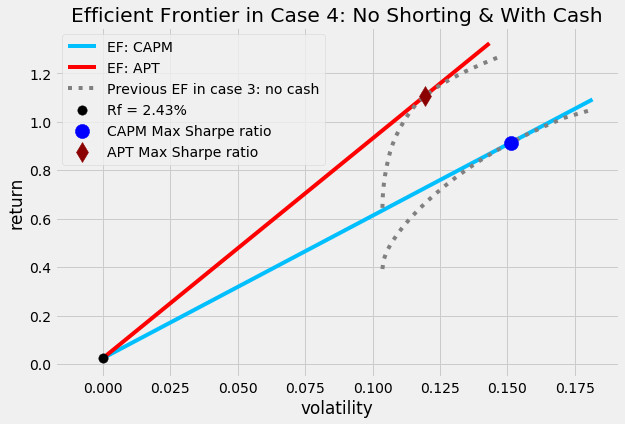

In [79]:
Rf=rf.iloc[-1,0] * 52  # annualized
cov_matrix = stock_df.iloc[-window-1:-1,:50].cov()*52
cov_V = np.matrix(cov_matrix.as_matrix())


portf_no_short_no_cash_CAPM, weights_no_short_no_cash_CAPM = no_short_no_cash(expect_return_CAPM.iloc[-1] * 52, cov_V, Rf)
weight1 = weights_no_short_no_cash_CAPM['Max_Sharpe']
weight2 = weights_no_short_no_cash_CAPM['Min_Var']

cov_portf_CAPM_4 = get_twoportf_cov(weight1, cov_V, weight2)
cov_portf_CAPM_4 = np.matrix(cov_portf_CAPM_4.as_matrix())

internal_return_CAPM_4 = portf_no_short_no_cash_CAPM['Max_Sharpe']['Return']
internal_sigma_CAPM_4 = portf_no_short_no_cash_CAPM['Max_Sharpe']['Sigma']

vol_CAPM_4,return_CAPM_4 = plot_EF_2(internal_return_CAPM_4, internal_sigma_CAPM_4, Rf)



portf_short_allow_no_cash_APT, weights_short_allow_no_cash_APT = short_allow_no_cash(expect_return_APT.iloc[-1]*52, cov_V, Rf)
weight1 = weights_short_allow_no_cash_APT['Max_Sharpe']
weight2 = weights_short_allow_no_cash_APT['Min_Var']
cov_portf_APT_4 = get_twoportf_cov(weight1, cov_V, weight2)
cov_portf_APT_4 = np.matrix(cov_portf_APT_4.as_matrix())

internal_return_APT_4 = portf_no_short_no_cash_APT['Max_Sharpe']['Return']
internal_sigma_APT_4 = portf_no_short_no_cash_APT['Max_Sharpe']['Sigma']

vol_APT_4,return_APT_4 = plot_EF_2(internal_return_APT_4, internal_sigma_APT_4, Rf)


plt.figure(figsize=(9, 6))

# plt.scatter(internal_sigma, internal_return, marker='o',color='b',s=300, label='CAPM Max Sharpe ratio')
plt.scatter(0, Rf, marker='.',color='black',s=350, label='Rf = %.2f%%'%(Rf*100),zorder=5)

plt.plot(vol_CAPM_4,return_CAPM_4,zorder=1,color='deepskyblue',label = 'EF: CAPM')
plt.plot(vol_APT_4,return_APT_4, zorder=1,color='r',label='EF: APT')

plt.scatter(v_Max_Sharpe_CAPM_3,r_Max_Sharpe_CAPM_3, marker='o',color='b',s=200, zorder=5, label='CAPM Max Sharpe ratio')
plt.scatter(v_Max_Sharpe_APT_3, r_Max_Sharpe_APT_3, marker='d',color='darkred',s=200, zorder=5, label='APT Max Sharpe ratio')

plt.plot(vol_CAPM_3,return_CAPM_3,zorder=1,linestyle=':', color='grey',label='Previous EF in case 3: no cash')
plt.plot(vol_APT_3,return_APT_3, zorder=1,linestyle=':', color='grey')

plt.title('Efficient Frontier in Case 4: No Shorting & With Cash')
plt.xlabel('volatility')
plt.ylabel('return')
plt.legend(labelspacing=0.5)
plt.show()

#### PLOT in Two Figures

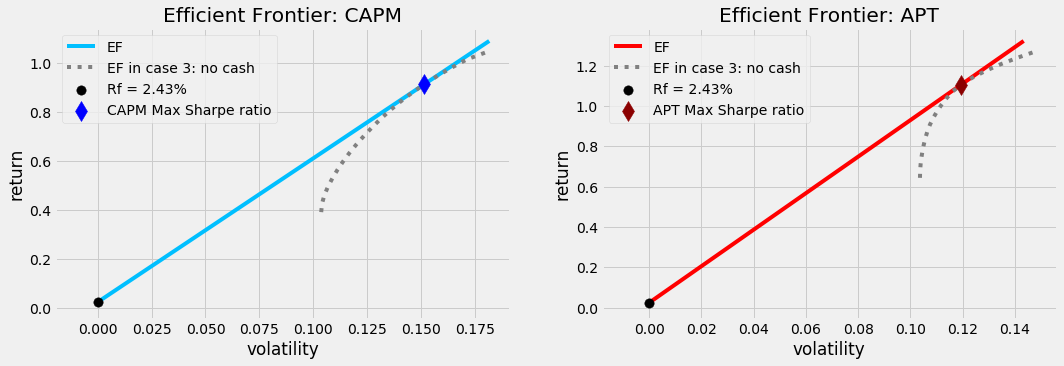

In [80]:
# PLOT in Two Figures
fig, axes = plt.subplots(1, 2, figsize=(16,5))

ax0 = axes[0]
ax0.scatter(0, Rf, marker='.',color='black',s=350, label='Rf = %.2f%%'%(Rf*100),zorder=5)
ax0.plot(vol_CAPM_4,return_CAPM_4,zorder=1,color='deepskyblue',label='EF')
ax0.scatter(v_Max_Sharpe_CAPM_3,r_Max_Sharpe_CAPM_3, marker='d',color='b',s=200, zorder=5, label='CAPM Max Sharpe ratio')

ax0.plot(vol_CAPM_3,return_CAPM_3,zorder=1,color='grey',linestyle=':',label='EF in case 3: no cash')
ax0.set_title('Efficient Frontier: CAPM')
ax0.set_xlabel('volatility')
ax0.set_ylabel('return')
ax0.legend(labelspacing=0.5)

ax1 = axes[1]
ax1.scatter(0, Rf, marker='.',color='black',s=350, label='Rf = %.2f%%'%(Rf*100),zorder=5)
ax1.plot(vol_APT_4,return_APT_4, zorder=1,color='r',label='EF')
ax1.scatter(v_Max_Sharpe_APT_3, r_Max_Sharpe_APT_3, marker='d',color='darkred',s=200, zorder=5, label='APT Max Sharpe ratio')

ax1.plot(vol_APT_3,return_APT_3, zorder=1,color='grey',linestyle=':',label='EF in case 3: no cash')
ax1.set_title('Efficient Frontier: APT')
ax1.set_xlabel('volatility')
ax1.set_ylabel('return')
ax1.legend(labelspacing=0.5)

# plt.tight_layout() 
plt.show()

### Compared with the former EFs in case 2, the new EFs (solid line) go downwards when shorting is not allowed

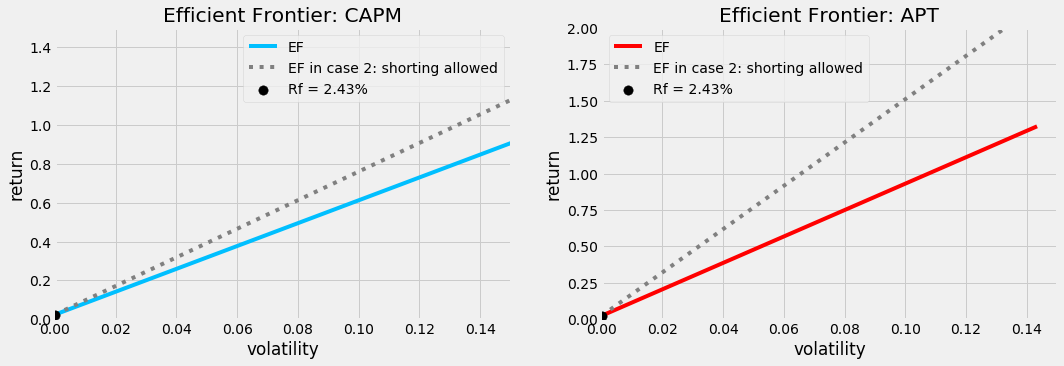

In [81]:
# PLOT in Two Figures
fig, axes = plt.subplots(1, 2, figsize=(16,5))

ax0 = axes[0]
ax0.scatter(0, Rf, marker='.',color='black',s=350, label='Rf = %.2f%%'%(Rf*100),zorder=5)
ax0.plot(vol_CAPM_4,return_CAPM_4,zorder=1,color='deepskyblue', label='EF')

ax0.plot(vol_CAPM_2,return_CAPM_2,zorder=1,color='grey',linestyle=':',label='EF in case 2: shorting allowed')
ax0.set_title('Efficient Frontier: CAPM')
ax0.set_xlabel('volatility')
ax0.set_ylabel('return')
ax0.legend(labelspacing=0.5)
ax0.set_xlim(0,0.15)
ax0.set_ylim(0,1.5)

ax1 = axes[1]
ax1.scatter(0, Rf, marker='.',color='black',s=350, label='Rf = %.2f%%'%(Rf*100),zorder=5)
ax1.plot(vol_APT_4,return_APT_4, zorder=1,color='r', label='EF')

ax1.plot(vol_APT_2,return_APT_2, zorder=1,color='grey',linestyle=':',label='EF in case 2: shorting allowed')
ax1.set_title('Efficient Frontier: APT')
ax1.set_xlabel('volatility')
ax1.set_ylabel('return')
ax1.legend(labelspacing=0.5)
ax1.set_xlim(0,0.15)
ax1.set_ylim(0,2)
# plt.tight_layout() 
plt.show()

# IV. Single Index Model

In [82]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [83]:
rm = pd.DataFrame(stock_df['SP500'])
rf = pd.DataFrame(bond_df['1MTB'][1:])
rf.tail()

,1MTB
2019-03-01,0.000469
2019-03-08,0.000471
2019-03-15,0.000473
2019-03-22,0.000479
2019-03-29,0.000467


### 4-1 Find the excess return to beta ratio for each stock

In [84]:
def Reg(ri):
    window = 150
    y = np.array(ri[-window:]) # Y = Ri
    X = sm.add_constant(rm[-window:])  # X = Rm
    model = sm.OLS(y, X).fit()    
    expect = model.predict()[-1]
    intercept = model.params[0]
    beta = model.params[1]
    var_ei = np.var((y - expect))
    rsquare = model.rsquared
    return expect, intercept, beta, var_ei, rsquare

In [85]:
expect_list = []; alpha_list = []; beta_list= []; var_ei_list = []; r2_list = []

for stock in stock_df.columns[:50]:
    ri = pd.DataFrame(stock_df[stock])
    expect, alpha, beta, var_ei, r2 = Reg(ri)
    expect_list.append(expect) 
    alpha_list.append(alpha)
    beta_list.append(beta)
    var_ei_list.append(var_ei)
    r2_list.append(r2)

In [86]:
expect_return_Reg = pd.DataFrame(expect_list,index = stock_df.columns[:50],columns=['expect_return'])
alpha_df = pd.DataFrame(alpha_list,index = stock_df.columns[:50],columns=['alpha'])
beta_df = pd.DataFrame(beta_list,index = stock_df.columns[:50],columns=['beta'])
var_ei_df = pd.DataFrame(var_ei_list,index = stock_df.columns[:50],columns=['var_ei'])
r2_df = pd.DataFrame(r2_list,index = stock_df.columns[:50],columns=['R_square'])
ols_df_SIM = pd.concat([expect_return_Reg, alpha_df, beta_df, var_ei_df, r2_df],axis=1)
ols_df_SIM.head(10)

,expect_return,alpha,beta,var_ei,R_square
MSFT,0.016076,0.003439,1.050507,0.000585,0.584068
AAPL,0.015414,0.003164,1.018404,0.001175,0.273512
AMZN,0.019830,0.003615,1.348010,0.001215,0.463130
GOOGL,0.015198,0.000881,1.190235,0.000833,0.526727
FB,0.014155,0.000183,1.161496,0.001328,0.314624
JNJ,0.008693,-0.000074,0.728763,0.000472,0.348575
XOM,0.008553,-0.002441,0.913999,0.000606,0.427085
JPM,0.015158,0.001050,1.172812,0.000849,0.501772
V,0.014956,0.002601,1.027032,0.000504,0.647996
WMT,0.009078,0.001663,0.616414,0.000766,0.153576


In [87]:
Rf_week=rf.iloc[-1,0]
Rf_week

0.0004673076923076923

In [88]:
stock_name = stock_df.columns[:50]
excess_return_over_beta = {}
Ri_dic = {}
beta_dic = {}
varei_dic = {}

for i in range(50):
    index = stock_name[i]
    excess_return_over_beta[index] = (expect_list[i]-Rf_week) / beta_list[i]
    Ri_dic[index] = expect_list[i]
    beta_dic[index] = beta_list[i]
    varei_dic[index] = var_ei_list[i]

### 4-2 Ranking stocks

In [89]:
import operator
sorted_x = sorted(excess_return_over_beta.items(), key=operator.itemgetter(1),reverse=True)
sorted_x[0][0]

'BA'

In [90]:
SIMM = pd.DataFrame(columns = ['stock_name','(Ri-Rf)/beta','(Ri-Rf)*beta/var_ei','beta**2/var_ei','sum((Ri-Rf)*beta/var_ei)','sum(beta**2/var_ei)','Ci','Zi','weight'])
for i in range(50):
    name = sorted_x[i][0]
    c = (Ri_dic[name]-Rf_week)*beta_dic[name]/varei_dic[name]
    d = beta_dic[name]**2/varei_dic[name]
    SIMM = SIMM.append({'stock_name':name, '(Ri-Rf)/beta':sorted_x[i][1],'(Ri-Rf)*beta/var_ei':c,'beta**2/var_ei':d}, ignore_index=True)
SIMM = SIMM.fillna(0)

SIMM.head(5)

,stock_name,(Ri-Rf)/beta,(Ri-Rf)*beta/var_ei,beta**2/var_ei,sum((Ri-Rf)*beta/var_ei),sum(beta**2/var_ei),Ci,Zi,weight
0,BA,0.016307,16.907766,1036.816485,0.0,0.0,0.0,0.0,0.0
1,NFLX,0.016247,12.648660,778.528405,0.0,0.0,0.0,0.0,0.0
2,ADBE,0.015656,20.899431,1334.895268,0.0,0.0,0.0,0.0,0.0
3,AVGO,0.015528,8.201519,528.174075,0.0,0.0,0.0,0.0,0.0
4,MA,0.015086,26.785635,1775.579258,0.0,0.0,0.0,0.0,0.0


### 4-3-1 Short sales not allowed - Calculating the cutoff rate (C*)

In [91]:
window=150
var_m=np.var(np.array(rm[-window:]),ddof=1)
var_m

0.0003118633506857126

In [92]:
SIMM['sum((Ri-Rf)*beta/var_ei)'][0] = SIMM['(Ri-Rf)*beta/var_ei'][0] 
SIMM['sum(beta**2/var_ei)'][0] = SIMM['beta**2/var_ei'][0] 
SIMM['Ci'][0] = var_m*SIMM['sum((Ri-Rf)*beta/var_ei)'][0]/(1+var_m*SIMM['sum(beta**2/var_ei)'][0])

for i in range(1,50):
    SIMM['sum((Ri-Rf)*beta/var_ei)'][i] = SIMM['sum((Ri-Rf)*beta/var_ei)'][i-1] + SIMM['(Ri-Rf)*beta/var_ei'][i]
    SIMM['sum(beta**2/var_ei)'][i] = SIMM['sum(beta**2/var_ei)'][i-1] + SIMM['beta**2/var_ei'][i]
    SIMM['Ci'][i] = var_m*SIMM['sum((Ri-Rf)*beta/var_ei)'][i]/(1+var_m*SIMM['sum(beta**2/var_ei)'][i])
    
SIMM.head(5)

,stock_name,(Ri-Rf)/beta,(Ri-Rf)*beta/var_ei,beta**2/var_ei,sum((Ri-Rf)*beta/var_ei),sum(beta**2/var_ei),Ci,Zi,weight
0,BA,0.016307,16.907766,1036.816485,16.907766,1036.816485,0.003985,0.0,0.0
1,NFLX,0.016247,12.648660,778.528405,29.556427,1815.344890,0.005886,0.0,0.0
2,ADBE,0.015656,20.899431,1334.895268,50.455858,3150.240158,0.007937,0.0,0.0
3,AVGO,0.015528,8.201519,528.174075,58.657377,3678.414234,0.008520,0.0,0.0
4,MA,0.015086,26.785635,1775.579258,85.443011,5453.993492,0.009866,0.0,0.0


In [93]:
maxx = SIMM[SIMM['Ci']==SIMM['Ci'].max()]
maxx.head(5)

,stock_name,(Ri-Rf)/beta,(Ri-Rf)*beta/var_ei,beta**2/var_ei,sum((Ri-Rf)*beta/var_ei),sum(beta**2/var_ei),Ci,Zi,weight
20,MRK,0.012902,14.488761,1122.980232,366.956366,25721.138123,0.012685,0.0,0.0


In [94]:
C_star = float(maxx['Ci'])

### 4-3-2 Short sales not allowed - Constructing the optimal portfolio

In [95]:
for i in range(21):
    name = SIMM['stock_name'][i]
    SIMM['Zi'][i] = beta_dic[name]/varei_dic[name]*((Ri_dic[name]-Rf_week)/beta_dic[name]-C_star)

    
sum_Zi = sum(SIMM['Zi'])
for i in range(21):
    name = SIMM['stock_name'][i]
    SIMM['weight'][i] = SIMM['Zi'][i]/sum_Zi

SIMM.head(5)

,stock_name,(Ri-Rf)/beta,(Ri-Rf)*beta/var_ei,beta**2/var_ei,sum((Ri-Rf)*beta/var_ei),sum(beta**2/var_ei),Ci,Zi,weight
0,BA,0.016307,16.907766,1036.816485,16.907766,1036.816485,0.003985,3.449486,0.092309
1,NFLX,0.016247,12.648660,778.528405,29.556427,1815.344890,0.005886,1.731831,0.046344
2,ADBE,0.015656,20.899431,1334.895268,50.455858,3150.240158,0.007937,3.447801,0.092264
3,AVGO,0.015528,8.201519,528.174075,58.657377,3678.414234,0.008520,1.594729,0.042675
4,MA,0.015086,26.785635,1775.579258,85.443011,5453.993492,0.009866,3.879495,0.103816


In [96]:
np.sum(np.array(SIMM['weight']))

1.0000000000000004

In [97]:
SIMM[['stock_name','weight']].head(5)

,stock_name,weight
0,BA,0.092309
1,NFLX,0.046344
2,ADBE,0.092264
3,AVGO,0.042675
4,MA,0.103816


In [98]:
s = SIMM.loc[SIMM['stock_name']==stock_name[0]]
s.iloc[0]['weight']

0.10435434317469666

In [99]:
Weight_no_short = pd.DataFrame(columns=['stock','weight'])
for i in range(50):
    name = stock_name[i]
    s = SIMM.loc[SIMM['stock_name']==name]
    weight = s.iloc[0]['weight']
    Weight_no_short = Weight_no_short.append({'stock':name,'weight':weight},ignore_index=True)

In [100]:
Weight_no_short.head()

,stock,weight
0,MSFT,0.104354
1,AAPL,0.046200
2,AMZN,0.049819
3,GOOGL,0.000000
4,FB,0.000000


### 4-4-1 Short sales allowed - Calculating the cutoff rate (C*)

In [101]:
C50=SIMM['Ci'][49]

### 4-4-2 Short sales allowed - Constructing the optimal portfolio

In [102]:
for i in range(50):
    name = SIMM['stock_name'][i]
    SIMM['Zi'][i] = beta_dic[name]/varei_dic[name]*((Ri_dic[name]-Rf_week)/beta_dic[name]-C50)
    
sum_Zi = sum(SIMM['Zi'])
for i in range(50):
    name = SIMM['stock_name'][i]
    SIMM['weight'][i] = SIMM['Zi'][i]/sum_Zi
    
SIMM.head(5)

,stock_name,(Ri-Rf)/beta,(Ri-Rf)*beta/var_ei,beta**2/var_ei,sum((Ri-Rf)*beta/var_ei),sum(beta**2/var_ei),Ci,Zi,weight
0,BA,0.016307,16.907766,1036.816485,16.907766,1036.816485,0.003985,4.340060,0.142773
1,NFLX,0.016247,12.648660,778.528405,29.556427,1815.344890,0.005886,2.186543,0.071929
2,ADBE,0.015656,20.899431,1334.895268,50.455858,3150.240158,0.007937,4.533037,0.149121
3,AVGO,0.015528,8.201519,528.174075,58.657377,3678.414234,0.008520,2.119321,0.069718
4,MA,0.015086,26.785635,1775.579258,85.443011,5453.993492,0.009866,5.390928,0.177342


In [103]:
np.sum(np.array((SIMM['weight'])))

0.9999999999999999

In [104]:
s = SIMM.loc[SIMM['stock_name']==stock_name[0]]
s.iloc[0]['weight']
Weight_short = pd.DataFrame(columns=['stock','weight'])
for i in range(50):
    name = stock_name[i]
    s = SIMM.loc[SIMM['stock_name']==name]
    weight = s.iloc[0]['weight']
    Weight_short = Weight_short.append({'stock':name,'weight':weight},ignore_index=True)
    
Weight_short.head(5)

,stock,weight
0,MSFT,0.183495
1,AAPL,0.083464
2,AMZN,0.095360
3,GOOGL,0.029440
4,FB,0.000988


In [105]:
Weight_all  =pd.merge(Weight_short,Weight_no_short,on='stock')
Weight_all.columns=['stock','shorting','no_shorting']
Weight_all.to_excel('SIM_weight.xlsx')

# 5 Comparison: Efficient Frontier vs. Optimal Portf. via Single Index Model

In [106]:
# df_sim = pd.read_excel('SIM_weight.xlsx')
df_sim = Weight_all

weight_SIM_CAPM_2 = df_sim['shorting']

# Shorting Allowed
r_SIM_CAPM_2, v_SIM_CAPM_2, s_SIM_CAPM_2 = get_return_sigma(expect_return_CAPM.iloc[-1] * 52, cov_V, df_sim['shorting'])
r_SIM_APT_2, v_SIM_APT_2, s_SIM_APT_2 = get_return_sigma(expect_return_APT.iloc[-1] * 52, cov_V, df_sim['shorting'])

# # Shorting NOT Allowed
r_SIM_CAPM_4, v_SIM_CAPM_4, s_SIM_CAPM_4 = get_return_sigma(expect_return_CAPM.iloc[-1] * 52, cov_V, df_sim['no_shorting'])
r_SIM_APT_4, v_SIM_APT_4, s_SIM_APT_4 = get_return_sigma(expect_return_APT.iloc[-1] * 52, cov_V, df_sim['no_shorting'])

## 5-1 Comparison Case 1: Shorting Allowed, Efficient Frontier vs. Single Index Model (Star)

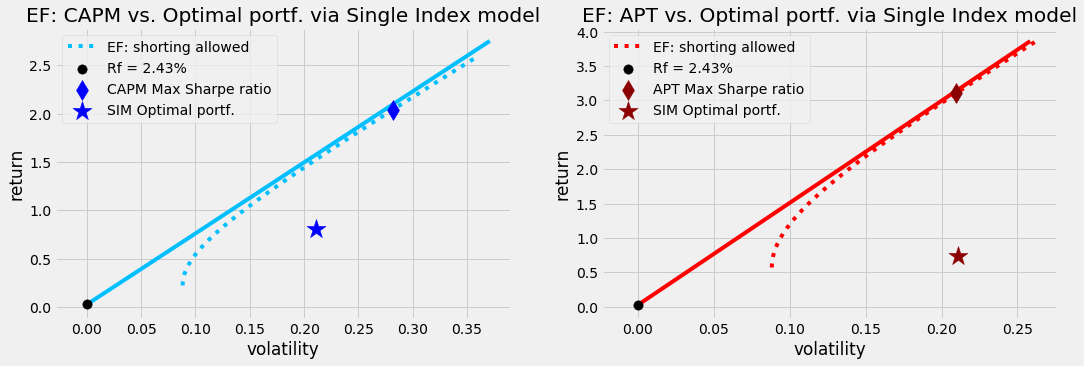

In [107]:
# PLOT in Two Figures
fig, axes = plt.subplots(1, 2, figsize=(16,5))

ax0 = axes[0]
ax0.scatter(0, Rf, marker='.',color='black',s=350, label='Rf = %.2f%%'%(Rf*100),zorder=5)
ax0.plot(vol_CAPM_2,return_CAPM_2,zorder=1,color='deepskyblue')
ax0.scatter(v_Max_Sharpe_CAPM_1,r_Max_Sharpe_CAPM_1, marker='d',color='b',s=200, zorder=5, label='CAPM Max Sharpe ratio')

ax0.scatter(v_SIM_CAPM_2, r_SIM_CAPM_2,color='b',s=400,marker='*',label='SIM Optimal portf.')

ax0.plot(vol_CAPM_1,return_CAPM_1,zorder=1,color='deepskyblue',linestyle=':',label='EF: shorting allowed')
ax0.set_title('EF: CAPM vs. Optimal portf. via Single Index model')
ax0.set_xlabel('volatility')
ax0.set_ylabel('return')
ax0.legend(labelspacing=0.5)


ax1 = axes[1]
ax1.scatter(0, Rf, marker='.',color='black',s=350, label='Rf = %.2f%%'%(Rf*100),zorder=5)
ax1.plot(vol_APT_2,return_APT_2, zorder=1,color='r')
ax1.scatter(v_Max_Sharpe_APT_1, r_Max_Sharpe_APT_1, marker='d',color='darkred',s=200, zorder=5, label='APT Max Sharpe ratio')

ax1.scatter(v_SIM_APT_2, r_SIM_APT_2,color='darkred',s=400,marker='*',label='SIM Optimal portf.')

ax1.plot(vol_APT_1,return_APT_1, zorder=1,color='r',linestyle=':',label='EF: shorting allowed')
ax1.set_title('EF: APT vs. Optimal portf. via Single Index model')
ax1.set_xlabel('volatility')
ax1.set_ylabel('return')
ax1.legend(labelspacing=0.5)

plt.show()

## 5-2 Comparison Case 2: Shorting Not Allowed, EF vs. Single Index Model (Star)

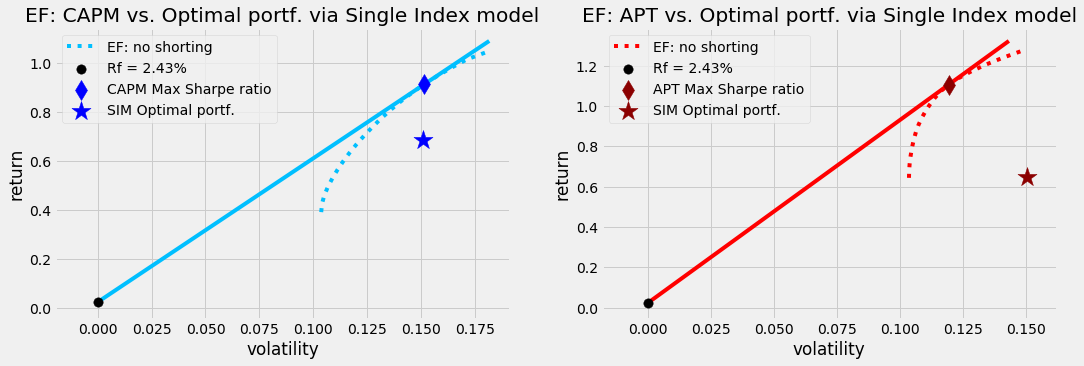

In [108]:
# PLOT in Two Figures
fig, axes = plt.subplots(1, 2, figsize=(16,5))

ax0 = axes[0]
ax0.scatter(0, Rf, marker='.',color='black',s=350, label='Rf = %.2f%%'%(Rf*100),zorder=5)
ax0.plot(vol_CAPM_4,return_CAPM_4,zorder=1,color='deepskyblue')
ax0.scatter(v_Max_Sharpe_CAPM_3,r_Max_Sharpe_CAPM_3, marker='d',color='b',s=200, zorder=5, label='CAPM Max Sharpe ratio')

ax0.scatter(v_SIM_CAPM_4, r_SIM_CAPM_4,color='b',s=400,marker='*',label='SIM Optimal portf.')

ax0.plot(vol_CAPM_3,return_CAPM_3,zorder=1,color='deepskyblue',linestyle=':',label='EF: no shorting')
ax0.set_title('EF: CAPM vs. Optimal portf. via Single Index model')
ax0.set_xlabel('volatility')
ax0.set_ylabel('return')
ax0.legend(labelspacing=0.5)

ax1 = axes[1]
ax1.scatter(0, Rf, marker='.',color='black',s=350, label='Rf = %.2f%%'%(Rf*100),zorder=5)
ax1.plot(vol_APT_4,return_APT_4, zorder=1,color='r')
ax1.scatter(v_Max_Sharpe_APT_3, r_Max_Sharpe_APT_3, marker='d',color='darkred',s=200, zorder=5, label='APT Max Sharpe ratio')

ax1.scatter(v_SIM_APT_4, r_SIM_APT_4,color='darkred',s=400,marker='*',label='SIM Optimal portf.')

ax1.plot(vol_APT_3,return_APT_3, zorder=1,color='r',linestyle=':',label='EF: no shorting')
ax1.set_title('EF: APT vs. Optimal portf. via Single Index model')
ax1.set_xlabel('volatility')
ax1.set_ylabel('return')
ax1.legend(labelspacing=0.5)

plt.show()